# 6. Кластеризация 

In [5]:
import pandas as pd

# Загружаем готовые данные
df = pd.read_parquet("hdfs_logs.parquet")

# Проверяем
print(df.shape)
df.head()

(11175629, 6)


,timestamp,level,component,message,BlockId,pid
0,2008-11-09 20:35:18,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906,143
1,2008-11-09 20:35:18,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,blk_-1608999687919862906,35
2,2008-11-09 20:35:19,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906,143
3,2008-11-09 20:35:19,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906,145
4,2008-11-09 20:35:19,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,blk_-1608999687919862906,145


### a. TF-IDF + KMeans/DBSCAN по векторизованным сообщениям

Мы рассматриваем tokenized_block как отдельный текстовый документ и применяем TF-IDF — метод, вычисляющий частоту терминов с учётом их редкости в других документах.
Такой подход позволяет преобразовать логи в числовые векторы, где более редкие, информативные слова и устойчивые сочетания (n-граммы) получают больший вес.
Полученные TF-IDF-вектора затем используются алгоритмами кластеризации (KMeans, DBSCAN) для выявления групп похожих логов и возможных аномалий.

In [6]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import save_npz
import joblib

# timestamp в нужном типе и сортируем
if not pd.api.types.is_datetime64_any_dtype(df["timestamp"]):
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.sort_values(["BlockId", "timestamp"], kind="mergesort")

# Нормализация текста
IP_RE      = re.compile(r"\b\d{1,3}(?:\.\d{1,3}){3}\b")
HEX_RE     = re.compile(r"\b[0-9a-fA-F]{6,}\b")
PATH_RE    = re.compile(r"(?:/[^ \t\n\r\f\v]+)+")
NUM_RE     = re.compile(r"\b\d+\b")
BLK_RE     = re.compile(r"\bblk_[\-\d]+\b")

def normalize_msg(s: str) -> str:
    s = s.lower()
    s = BLK_RE.sub(" <blk> ", s)
    s = IP_RE.sub(" <ip> ", s)
    s = PATH_RE.sub(" <path> ", s)
    s = HEX_RE.sub(" <hex> ", s)
    s = NUM_RE.sub(" <num> ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

#уровень (level)
def row_to_token(row) -> str:
    msg = normalize_msg(str(row["message"]))
    comp = str(row["component"]).split("$")[0].lower() if pd.notna(row["component"]) else ""
    level = str(row["level"]).lower() if pd.notna(row["level"]) else ""
    # токенизируем событие как: <comp>_<level>: msg
    return f"{comp}_{level}__ {msg}"

event_tokens = df.apply(row_to_token, axis=1)

# Собираем tokenized_block по BlockId ($в хронологическом порядке)
df_blocks = (
    pd.DataFrame({"BlockId": df["BlockId"].astype("string"), "tok": event_tokens})
      .groupby("BlockId", as_index=False)["tok"]
      .apply(lambda x: " . ".join(x))     # разделяем события внутри блока точкой
      .rename(columns={"tok": "tokenized_block"})
)

print("Количество блоков:", len(df_blocks))
display(df_blocks.head())

# TF-IDF по блокам
# можно увеличить max_features до 10000/20000
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),         # отдельные слова (1-граммы), так и устойчивые пары слов (2-граммы)
    min_df=3,                   # игнорируем термины, которые встречаются менее чем в 3 блоках (слишком редкие)
    max_df=0.95,                # исключаем термины, встречающиеся в более чем 95 % блоков (слишком частые)
    token_pattern=r"(?u)\b\w+\b",
    stop_words="english"        # удаляем английские стоп-слова (в логах это помогает убрать лишние служебные термины)
)

X_blocks = vectorizer.fit_transform(df_blocks["tokenized_block"])
print("TF-IDF матрица блоков:", X_blocks.shape)   # (число блоков, число признаков)

# Сохраняем для дальнейших шагов
df_blocks.to_parquet("hdfs_blocks_tokenized.parquet")
save_npz("tfidf_blocks.npz", X_blocks)           # разреженная матрица
joblib.dump(vectorizer, "tfidf_blocks_vectorizer.joblib")

# проверка:какие слова и фразы TF-IDF считает самыми важными
feature_names = vectorizer.get_feature_names_out()
for i in range(3):
    row = X_blocks[i].toarray().ravel()
    top = row.argsort()[-10:][::-1]
    print(f"\nBlockId={df_blocks.iloc[i]['BlockId']}")
    print("Top terms:", [feature_names[j] for j in top])
    print("Snippet:", df_blocks.iloc[i]["tokenized_block"][:200], "...")

Количество блоков: 575061


,BlockId,tokenized_block
0,blk_-1000002529962039464,dfs.datanode_info__ receiving block <blk> src:...
1,blk_-100000266894974466,dfs.fsnamesystem_info__ block* namesystem.allo...
2,blk_-1000007292892887521,dfs.datanode_info__ receiving block <blk> src:...
3,blk_-1000014584150379967,dfs.datanode_info__ receiving block <blk> src:...
4,blk_-1000028658773048709,dfs.datanode_info__ receiving block <blk> src:...


TF-IDF матрица блоков: (575061, 250)

BlockId=blk_-1000002529962039464
Top terms: ['written dfs', 'exception java', 'fsdataset_info__ deleting', 'fsdataset_info__', 'file path', 'file offset', 'file dfs', 'file', 'failed transfer', 'failed']
Snippet: dfs.datanode_info__ receiving block <blk> src: / <ip> : <num> dest: / <ip> : <num> . dfs.datanode_info__ receiving block <blk> src: / <ip> : <num> dest: / <ip> : <num> . dfs.datanode_info__ receiving  ...

BlockId=blk_-100000266894974466
Top terms: ['blk ip', 'served block', 'served', 'num served', 'datanode_info__ ip', 'serving', 'got exception', 'exception serving', 'serving blk', 'datanode_warn__']
Snippet: dfs.fsnamesystem_info__ block* namesystem.allocateblock: <path> <blk> . dfs.datanode_info__ receiving block <blk> src: / <ip> : <num> dest: / <ip> : <num> . dfs.datanode_info__ receiving block <blk> s ...

BlockId=blk_-1000007292892887521
Top terms: ['written dfs', 'exception java', 'fsdataset_info__ deleting', 'fsdataset_info__', 'f

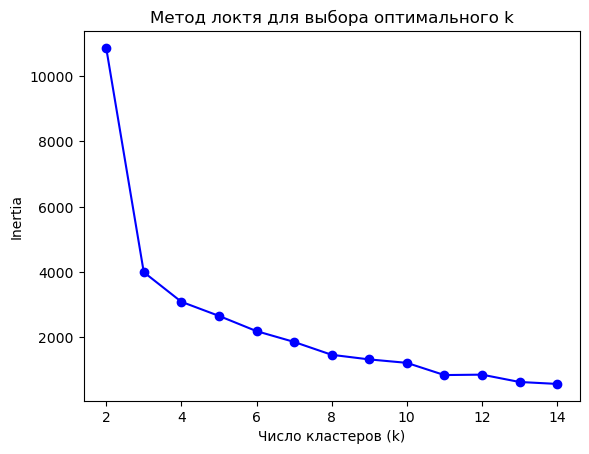

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

inertias = []
K = range(2, 15)

for k in K:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=4096, n_init="auto")
    kmeans.fit(X_small)  # возьми сэмпл (X_small — например, 30k точек)
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, 'bo-')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Inertia')
plt.title('Метод локтя для выбора оптимального k')
plt.show()

In [8]:
# FDBSCAN: Ускорение алгоритма DBSCAN за счет использования алгоритма K-means (Ссылка на статью: https://old.mipt.ru/upload/medialibrary/4a3/77-81.pdf)
import os, numpy as np, pandas as pd
from scipy.sparse import load_npz
from sklearn.preprocessing import normalize as sp_normalize
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

# Параметры
K = 15                   # промежуточные кластеры KMeans 
t = 0.50                 # доля ближних к центроиду из каждого KMeans-кластера
MIN_SAMPLES = 5          # для DBSCAN (k в k-distance)
EPS_MULTIPLIER = 0.9     # множитель к робастной оценке eps (0.9..1.3)
MAX_PER_K = 2000         # максимум точек E из одного KMeans-кластера
MAX_E_TOTAL = 50_000     # общий потолок размера E
SAMPLE_KDIST = 20_000    # на скольких точках строим k-distance
RANDOM_STATE = 42
BATCH_SIZE = 4096
MAX_ITERS_KMEANS = 50

# Достаём данные
if "df_blocks" in globals() and "X_blocks" in globals():
    df = df_blocks.copy()
    X = X_blocks
    print("Использую df_blocks и X_blocks из памяти.")
else:
    print("Пробую подхватить сохранённые файлы…")
    if not os.path.exists("hdfs_blocks_tokenized.parquet") or not os.path.exists("tfidf_blocks.npz"):
        raise RuntimeError("Нет df_blocks/X_blocks в памяти И нет файлов hdfs_blocks_tokenized.parquet/tfidf_blocks.npz.")
    df = pd.read_parquet("hdfs_blocks_tokenized.parquet")   
    X = load_npz("tfidf_blocks.npz")
    print("Загружено с диска.")

N, D = X.shape
print(f"TF-IDF размер: {N}×{D}")

# L2-нормировка sparse (евклид ~ косинусу) 
Xn = sp_normalize(X, norm="l2", copy=False)

# MiniBatchKMeans
km = MiniBatchKMeans(
    n_clusters=K, batch_size=BATCH_SIZE, max_iter=MAX_ITERS_KMEANS,
    n_init="auto", random_state=RANDOM_STATE
)
km.fit(Xn)
labels = km.labels_
df["kmeans_label"] = labels

# расстояние до своего центроида (евклид в L2-нормированном пространстве)
d_all = km.transform(Xn)                                # (N, K)
dist_to_ctr = d_all[np.arange(N), labels].astype(np.float32)
df["dist_to_centroid"] = dist_to_ctr
print("KMeans готов.")

# Формируем E: top-t% внутри каждого кластера + лимиты 
keep = np.zeros(N, dtype=bool)
kept = 0
for k in range(K):
    idx = np.where(labels == k)[0]
    if idx.size == 0:
        continue
    n_keep = min(max(1, int(np.ceil(t * idx.size))), MAX_PER_K)
    chosen = idx[np.argsort(dist_to_ctr[idx])[:n_keep]]     # самые близкие к центроиду
    keep[chosen] = True
    kept += chosen.size
    if kept >= MAX_E_TOTAL:
        pick = np.where(keep)[0]
        np.random.shuffle(pick)
        keep[:] = False
        keep[pick[:MAX_E_TOTAL]] = True
        break

E_idx = np.where(keep)[0]
Xe = Xn[E_idx]
print(f"E size: {Xe.shape[0]} (лимит {MAX_E_TOTAL})")

# eps по k-distance (устойчивый к нулям и дубликатам)
k = max(2, MIN_SAMPLES)

# берём сэмпл для k-distance
samp = E_idx if E_idx.size <= SAMPLE_KDIST else np.random.choice(E_idx, SAMPLE_KDIST, replace=False)
Xk = Xn[samp]

# n_neighbors=k+1: первая колонка — self (0), её уберём
nbrs = NearestNeighbors(n_neighbors=k + 1, metric="cosine")
nbrs.fit(Xk)
dists, _ = nbrs.kneighbors(Xk)

# расстояние до k-го ИНОГО соседа
k_d = np.sort(dists[:, 1:][:, -1])

# берём только ненулевые расстояния
nz = k_d[k_d > 1e-12]
if nz.size >= 100:
    q1, q3 = np.percentile(nz, [25, 75])
    iqr = max(1e-12, q3 - q1)
    eps = float((q3 + 1.5 * iqr) * EPS_MULTIPLIER)
elif nz.size > 0:
    eps = float(np.percentile(nz, 95))  # для маленьких сэмплов
else:
    eps = 0.05  # полностью дублирующиеся точки — берём вменяемый дефолт

# разумный диапазон для cosine
eps = float(np.clip(eps, 1e-3, 0.3))
print(f"eps ≈ {eps:.4f} (cosine)")

# DBSCAN на E 
db = DBSCAN(eps=eps, min_samples=MIN_SAMPLES, metric="cosine", n_jobs=-1)
db.fit(Xe)
E_labels = db.labels_

# Пропагация меток: переносим метки кластеров с ядровых (core) точек DBSCAN
# на остальные объекты. Каждая точка получает метку ближайшего ядра,
# а если она слишком далеко — считаем её аномалией (-1).
core_idx = getattr(db, "core_sample_indices_", None)
if core_idx is not None and len(core_idx) > 0:
    Xcore = Xe[core_idx]
    ycore = E_labels[core_idx]
    nn = NearestNeighbors(n_neighbors=1, metric="cosine")
    nn.fit(Xcore)
    dist_to_core, hit = nn.kneighbors(Xn, return_distance=True)
    dist_to_core = dist_to_core.ravel()
    hit = hit.ravel()
    prop = ycore[hit]
    prop[dist_to_core > eps] = -1   # далеко от ближайшего core — аномалия
else:
    prop = np.full(N, -1, dtype=int)

df["fdbscan_label"] = prop
df["is_anomaly"] = (prop == -1)

n_anom = int(df["is_anomaly"].sum())
n_clusters = len({x for x in prop if x != -1})
print(f"ИТОГО: кластеров={n_clusters}, аномалий={n_anom} ({n_anom/len(df):.2%})")

# Сохранение и превью
df.to_parquet("fdbscan_blocks.fast.parquet", index=False)
np.save("fdbscan_labels.fast.npy", prop)
print("Saved: fdbscan_blocks.fast.parquet, fdbscan_labels.fast.npy")

display(df[df["is_anomaly"]][["BlockId","kmeans_label","dist_to_centroid","fdbscan_label","tokenized_block"]].head(5))

Пробую подхватить сохранённые файлы…
Загружено с диска.
TF-IDF размер: 575061×250
KMeans готов.
E size: 29593 (лимит 50000)
eps ≈ 0.3000 (cosine)
ИТОГО: кластеров=4, аномалий=101050 (17.57%)
Saved: fdbscan_blocks.fast.parquet, fdbscan_labels.fast.npy


,BlockId,kmeans_label,dist_to_centroid,fdbscan_label,tokenized_block
0,blk_-1000002529962039464,1,0.005167,-1,dfs.datanode_info__ receiving block <blk> src:...
2,blk_-1000007292892887521,1,0.005167,-1,dfs.datanode_info__ receiving block <blk> src:...
5,blk_-100004553717737248,1,0.005167,-1,dfs.datanode_info__ receiving block <blk> src:...
27,blk_-100054792011350725,1,0.005167,-1,dfs.datanode_info__ receiving block <blk> src:...
28,blk_-1000583943604118788,1,0.005167,-1,dfs.datanode_info__ receiving block <blk> src:...


In [21]:
# Сводка по кластерам 
summary = (
    df.groupby("fdbscan_label")
      .agg(count=("BlockId", "count"), example=("tokenized_block", "first"))
      .sort_values("count", ascending=False)
)
print("Сводка по кластерам DBSCAN:")
display(summary.head(10))

# === Несколько случайных аномалий ===
anom = df[df["is_anomaly"]].sample(15, random_state=42)
display(anom[["BlockId", "kmeans_label", "dist_to_centroid", "tokenized_block"]])

# === Частые токены для аномалий и нормальных ===
import re, collections

def bag(text):
    return [w for w in re.split(r"[^\w<>]+", text.lower()) if len(w) > 2]

def top_terms(series, topn=25):
    cnt = collections.Counter()
    for s in series.head(50_000):
        cnt.update(bag(s))
    return cnt.most_common(topn)

top_anom = top_terms(df.loc[df["is_anomaly"], "tokenized_block"])
top_norm = top_terms(df.loc[~df["is_anomaly"], "tokenized_block"])

print("\nТоп-термины (аномалии):", top_anom[:15])
print("\nТоп-термины (нормальные):", top_norm[:15])

Сводка по кластерам DBSCAN:


,count,example
fdbscan_label,,
0,461800,dfs.fsnamesystem_info__ block* namesystem.allo...
-1,101050,dfs.datanode_info__ receiving block <blk> src:...
2,5103,dfs.datanode_info__ receiving block <blk> src:...
3,3883,dfs.fsnamesystem_info__ block* namesystem.allo...
1,3225,dfs.datanode_info__ receiving block <blk> src:...


,BlockId,kmeans_label,dist_to_centroid,tokenized_block
464309,blk_6111432748327671676,1,0.005167,dfs.datanode_info__ receiving block <blk> src:...
500915,blk_7172514200804497093,1,0.005167,dfs.datanode_info__ receiving block <blk> src:...
234050,blk_-775448788140718396,1,0.005167,dfs.datanode_info__ receiving block <blk> src:...
106014,blk_-4068893212267648988,1,0.005167,dfs.datanode_info__ receiving block <blk> src:...
157977,blk_-5568692728614395449,1,0.005167,dfs.datanode_info__ receiving block <blk> src:...
325506,blk_2095658928666844169,1,0.005167,dfs.datanode_info__ receiving block <blk> src:...
213419,blk_-7169908687296440453,1,0.005167,dfs.datanode_info__ receiving block <blk> src:...
240116,blk_-7926393671372055380,1,0.005167,dfs.datanode_info__ receiving block <blk> src:...
224042,blk_-7467756077334049053,1,0.005167,dfs.datanode_info__ receiving block <blk> src:...
221125,blk_-7385436113545574419,1,0.005167,dfs.datanode_info__ receiving block <blk> src:...



Топ-термины (аномалии): [('<blk>', 643227), ('dfs', 641035), ('block', 640744), ('<num>', 589927), ('<ip>', 589655), ('datanode_info__', 439900), ('size', 292300), ('<hex>', 292190), ('namesystem', 198706), ('fsnamesystem_info__', 198390), ('added', 148121), ('receiving', 147937), ('for', 147348), ('src', 147314), ('dest', 147314)]

Топ-термины (нормальные): [('<blk>', 1189138), ('dfs', 1041629), ('block', 991662), ('<ip>', 917804), ('<num>', 835618), ('datanode_info__', 496203), ('fsnamesystem_info__', 348139), ('namesystem', 347437), ('size', 300318), ('<hex>', 300224), ('added', 297308), ('<path>', 197509), ('for', 161707), ('src', 151167), ('dest', 151167)]


Saved: hdfs_fdbscan_2d.png


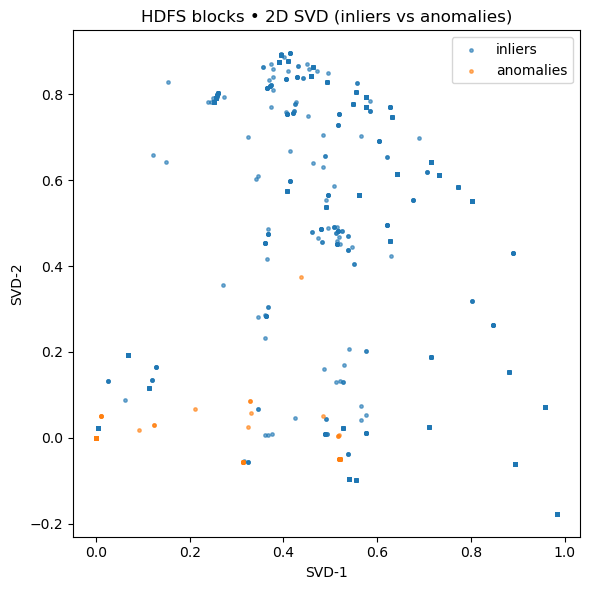

In [22]:
#2D визуализация результатов: inliers vs anomalies
# Берём df/X из памяти, иначе читаем fdbscan_blocks.fast.parquet + tfidf_blocks.npz.
import os, numpy as np, pandas as pd
from scipy.sparse import load_npz
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize as sp_normalize
import matplotlib.pyplot as plt

# 1) источники
df = globals().get("df", None)
X  = globals().get("X_blocks", None)

if df is None:
    if not os.path.exists("fdbscan_blocks.fast.parquet"):
        raise FileNotFoundError("Нет df в памяти и файла fdbscan_blocks.fast.parquet рядом.")
    df = pd.read_parquet("fdbscan_blocks.fast.parquet")

if X is None:
    if not os.path.exists("tfidf_blocks.npz"):
        raise FileNotFoundError("Нет X_blocks в памяти и файла tfidf_blocks.npz рядом.")
    X = load_npz("tfidf_blocks.npz")

# 2) 2D-проекция (SVD по sparse)
Xn = sp_normalize(X, norm="l2", copy=False)
svd2 = TruncatedSVD(n_components=2, random_state=42)
X2 = svd2.fit_transform(Xn)  # (N,2)

# 3) сэмпл для рисования, чтобы было быстро
N = X2.shape[0]
max_points = 20000
rng = np.random.RandomState(42)
idx = rng.choice(N, size=min(N, max_points), replace=False)

labels = df["fdbscan_label"].to_numpy()
anom_mask   = labels[idx] == -1
inlier_mask = ~anom_mask

# 4) рисуем одним графиком (без кастомных цветов, как просили)
plt.figure(figsize=(6,6))
plt.scatter(X2[idx][inlier_mask,0], X2[idx][inlier_mask,1], s=6, alpha=0.6, label="inliers")
plt.scatter(X2[idx][anom_mask,0],   X2[idx][anom_mask,1],   s=6, alpha=0.6, label="anomalies")
plt.title("HDFS blocks • 2D SVD (inliers vs anomalies)")
plt.xlabel("SVD-1"); plt.ylabel("SVD-2"); plt.legend(loc="best"); plt.tight_layout()

out_path = "hdfs_fdbscan_2d.png"
plt.savefig(out_path, dpi=200)
print("Saved:", out_path)

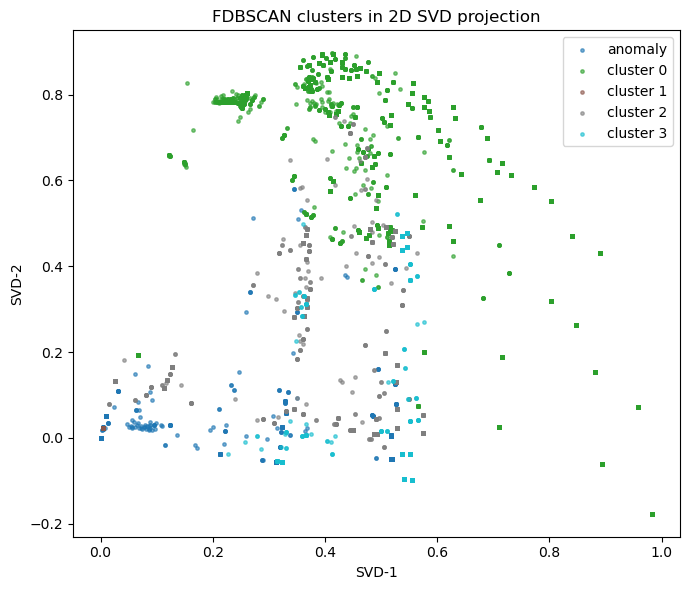

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

labels = df["fdbscan_label"].to_numpy()
unique_labels = np.unique(labels)

colors = cm.tab10(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(7,6))
for color, lab in zip(colors, unique_labels):
    mask = labels == lab
    plt.scatter(X2[mask,0], X2[mask,1], s=6, alpha=0.6, color=color,
                label=("anomaly" if lab == -1 else f"cluster {lab}"))
plt.legend()
plt.title("FDBSCAN clusters in 2D SVD projection")
plt.xlabel("SVD-1")
plt.ylabel("SVD-2")
plt.tight_layout()
plt.show()

In [24]:
rare = df[df["is_anomaly"]].sample(20, random_state=42)
display(rare[["BlockId","tokenized_block"]])

,BlockId,tokenized_block
464309,blk_6111432748327671676,dfs.datanode_info__ receiving block <blk> src:...
500915,blk_7172514200804497093,dfs.datanode_info__ receiving block <blk> src:...
234050,blk_-775448788140718396,dfs.datanode_info__ receiving block <blk> src:...
106014,blk_-4068893212267648988,dfs.datanode_info__ receiving block <blk> src:...
157977,blk_-5568692728614395449,dfs.datanode_info__ receiving block <blk> src:...
325506,blk_2095658928666844169,dfs.datanode_info__ receiving block <blk> src:...
213419,blk_-7169908687296440453,dfs.datanode_info__ receiving block <blk> src:...
240116,blk_-7926393671372055380,dfs.datanode_info__ receiving block <blk> src:...
224042,blk_-7467756077334049053,dfs.datanode_info__ receiving block <blk> src:...
221125,blk_-7385436113545574419,dfs.datanode_info__ receiving block <blk> src:...


In [25]:
print(pca3.explained_variance_ratio_)
print("Суммарно:", pca3.explained_variance_ratio_.sum())

[0.55246984 0.25958827 0.09711527]
Суммарно: 0.90917338492704


#### b. PCA / t-SNE для визуализации кластеров логов.

Кластеров: 4 + аномалии


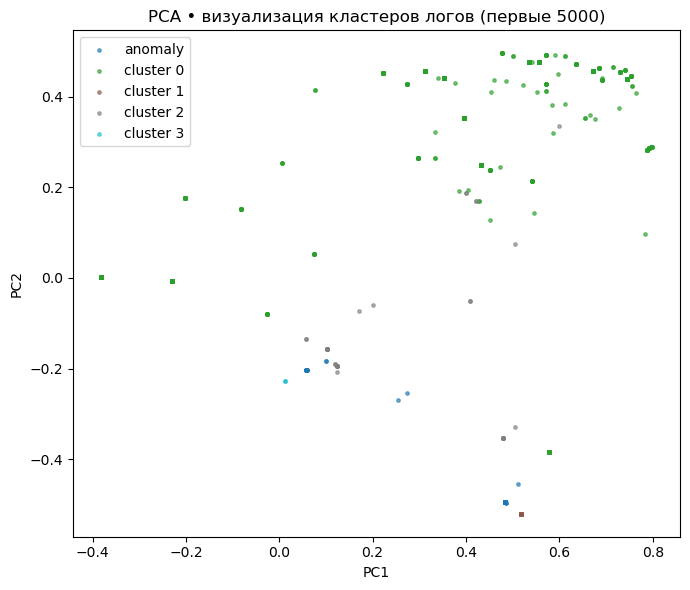

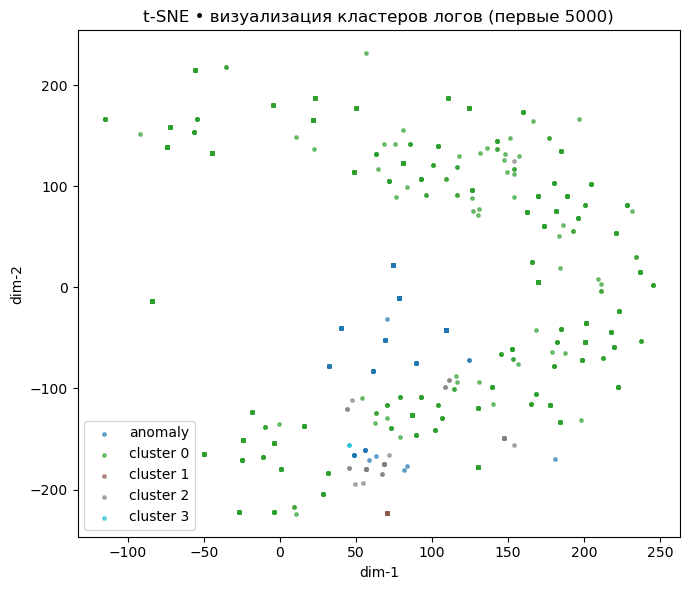

In [26]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize as sp_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm


if "df" not in globals():
    df = pd.read_parquet("fdbscan_blocks.fast.parquet")
if "X_blocks" not in globals():
    from scipy.sparse import load_npz
    X_blocks = load_npz("tfidf_blocks.npz")

labels = df["fdbscan_label"].to_numpy()
unique_labels = np.unique(labels)
print(f"Кластеров: {len(unique_labels)-1} + аномалии")

# 2. PCA (2 компоненты) 
Xn = sp_normalize(X_blocks, norm="l2", copy=False)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(Xn.toarray()[:5000])  # возьмём часть данных (быстрее)

# 3. Визуализация PCA 
colors = cm.tab10(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(7,6))
for color, lab in zip(colors, unique_labels):
    mask = (labels[:5000] == lab)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=6, alpha=0.6,
                color=color, label=("anomaly" if lab == -1 else f"cluster {lab}"))
plt.legend()
plt.title("PCA • визуализация кластеров логов (первые 5000)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# 4. t-SNE (на PCA-сжатых данных) 
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_pca)

# 5. Визуализация t-SNE 
plt.figure(figsize=(7,6))
for color, lab in zip(colors, unique_labels):
    mask = (labels[:5000] == lab)
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], s=6, alpha=0.6,
                color=color, label=("anomaly" if lab == -1 else f"cluster {lab}"))
plt.legend()
plt.title("t-SNE • визуализация кластеров логов (первые 5000)")
plt.xlabel("dim-1")
plt.ylabel("dim-2")
plt.tight_layout()
plt.show()

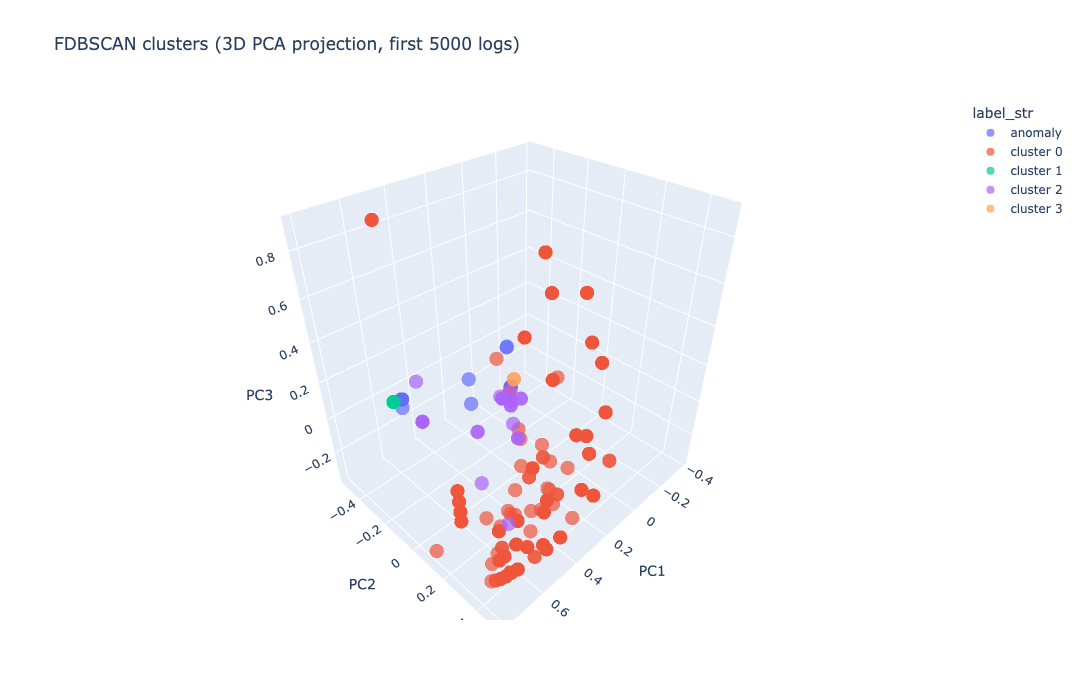

In [27]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize as sp_normalize
import numpy as np

# 1. Подготовка данных
Xn = sp_normalize(X_blocks, norm="l2", copy=False)
pca3 = PCA(n_components=3, random_state=42)
X3 = pca3.fit_transform(Xn.toarray()[:5000])

labels = df["fdbscan_label"].to_numpy()[:5000]

# 2. Создаём DataFrame для визуализации
vis_df = pd.DataFrame({
    "PC1": X3[:,0],
    "PC2": X3[:,1],
    "PC3": X3[:,2],
    "label": labels
})

vis_df["label_str"] = vis_df["label"].apply(lambda x: "anomaly" if x == -1 else f"cluster {x}")

# 3. 3D 
fig = px.scatter_3d(
    vis_df, x="PC1", y="PC2", z="PC3",
    color="label_str", opacity=0.7,
    title="FDBSCAN clusters (3D PCA projection, first 5000 logs)",
    width=800, height=700
)
fig.show()